# NOTICE: Thank you  Peter D. Hoff and Xiaoyue Niu - Hoff and Niu (2012)

### Hoff, P. and Niu, X., A Covariance Regression Model. Statistica Sinica, Institute of Statistical Science, 2012, 22(2), 729–753.

# Notebook Intended for New Users

### This reproduces the figures from Hoff and Niu (2012) using our code to reproduce their work as proof of concept.

## Import required packages

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]  # resize figures

sns.set(style='darkgrid')  # style of plot (dark grey background, etc)

## Load Raw Data

In [12]:
# load raw data
raw_data = pd.read_csv('../Peter_Hoff_Data/peter_hoff_data', header=0)
raw_data = np.asarray(raw_data)

## Prepare Data

In [13]:
# prepare data
peter_hoff_data = np.zeros((654, 3))

for row in range(654):

    if row < 309:
        peter_hoff_data[row, 0] = int(raw_data[row, 0][2])
    else:
        peter_hoff_data[row, 0] = int(raw_data[row, 0][1:3])

    if peter_hoff_data[row, 0] == 3:  # original paper groups those aged 3 into age 4
        peter_hoff_data[row, 0] = 4
    elif peter_hoff_data[row, 0] == 19:  # original paper groups those aged 19 into age 18
        peter_hoff_data[row, 0] = 18
    peter_hoff_data[row, 1] = float(raw_data[row, 0][4:10])  # fev values always 6 text values
    peter_hoff_data[row, 2] = float(raw_data[row, 0][11:15])  # height values always 4 text values

peter_hoff_data = pd.DataFrame(peter_hoff_data, columns=['age', 'fev', 'height'])

## Load Required Functions

In [14]:
from CovRegpy import cov_reg_given_mean

## Define Cubic B-Spline Functions

In [15]:
def b(knots, time, degree):
    """
    Recursive method for building basis functions - concise and effective.

    Parameters
    ----------
    knots : real ndarray
        Entire knot vector or subset of knot vector depending on level of recursion.
        Number of knots provided depends on degree of basis function i.e. degree = 3 -> len(knots) = 5

    time : real ndarray
        Time over which basis functions will be defined.

    degree : positive integer
        Degree of basis spline to be constructed.

    Returns
    -------
    output : real ndarray
        Single basis spline of degree: "degree".

    Notes
    -----
    Continually subsets knot vector by one increment until base case is reached.

    """
    if degree == 0:

        output = ((knots[0] <= time) & (time < knots[1])) * 1.0

        return output

    else:

        c1 = (time - knots[0] * np.ones_like(time)) / \
             (knots[-2] * np.ones_like(time) - knots[0] * np.ones_like(time)) * b(knots[0:-1], time, degree - 1)

        c2 = (knots[-1] * np.ones_like(time) - time) / \
             (knots[-1] * np.ones_like(time) - knots[1] * np.ones_like(time)) * b(knots[1:], time, degree - 1)

        output = c1 + c2

    return output


def cubic_b_spline(knots, time):
    """
    Returns a (len(knots) - 4) x len(time) array. Each row is an individual cubic basis.
    Matrix is sparse. Each column contains at most 4 non-zero values (only four bases overlap at any point).

    Parameters
    ----------
    knots : real ndarray
        Knot points to be used (not necessarily evenly spaced).

    time : real ndarray
        Time over which basis matrix will be defined.

    Returns
    -------
    matrix_c : real ndarray
        Each row of matrix contains an individual cubic basis spline.

    Notes
    -----
    A vector 'c' can be calculated such that with output of this function being array 'B' and a time series being 's'
    the objective function ||(B^T)c - s||^2 is minimized to yield coefficient vector 'c'.

    """
    num_c = len(knots) - 4  # cubic basis-spline -> 4 fewer coefficients than knots

    matrix_c = np.zeros((num_c, len(time)))  # each row is a single basis function

    for tau in range(num_c):  # watch inequalities

        temp_knots = knots[tau:(tau + 5)]  # select 5 knots applicable to current cubic spline

        matrix_c[tau, :] = b(temp_knots, time, 3)  # calls func b above

    return matrix_c

## Fit Model

In [16]:
# knots and time used in original paper
spline_basis = cubic_b_spline(knots=np.linspace(-17, 39, 9), time=np.linspace(4, 18, 15))
spline_basis = np.vstack((spline_basis, np.linspace(4, 18, 15)))

age_vector = np.asarray(peter_hoff_data['age'])
spline_basis_transform = np.zeros((6, 654))
for col in range(len(age_vector)):
    spline_basis_transform[:, col] = spline_basis[:, int(age_vector[col] - 4)]

coef_fev = np.linalg.lstsq(spline_basis_transform.transpose(), np.asarray(peter_hoff_data['fev']), rcond=None)
coef_fev = coef_fev[0]
mean_fev = np.matmul(coef_fev, spline_basis)

coef_height = np.linalg.lstsq(spline_basis_transform.transpose(), np.asarray(peter_hoff_data['height']), rcond=None)
coef_height = coef_height[0]
mean_height = np.matmul(coef_height, spline_basis)

x_cov = np.vstack((np.ones((1, 654)), (age_vector ** (1 / 2)).reshape(1, 654), age_vector.reshape(1, 654)))
y = np.vstack((np.asarray(peter_hoff_data['fev']).reshape(1, 654),
               np.asarray(peter_hoff_data['height']).reshape(1, 654)))
# mean = np.vstack((np.matmul(coef_fev, spline_basis_transform), np.matmul(coef_height, spline_basis_transform)))
A_est = np.hstack((coef_fev.reshape(6, 1), coef_height.reshape(6, 1)))
B_est, Psi_est = cov_reg_given_mean(A_est=A_est, basis=spline_basis_transform, x=x_cov, y=y, iterations=100)

mod_x_cov = np.vstack((np.ones((1, 15)),
                       (np.linspace(4, 18, 15) ** (1 / 2)).reshape(1, 15),
                       np.linspace(4, 18, 15).reshape(1, 15)))

# mean and covariance plots

cov_3d = np.zeros((2, 2, 15))
for depth in range(np.shape(cov_3d)[2]):
    cov_3d[:, :, depth] = Psi_est + np.matmul(np.matmul(B_est.T, mod_x_cov[:, depth]).reshape(2, -1),
                                              np.matmul(mod_x_cov[:, depth].T, B_est).reshape(-1, 2))

## Plot Covariance

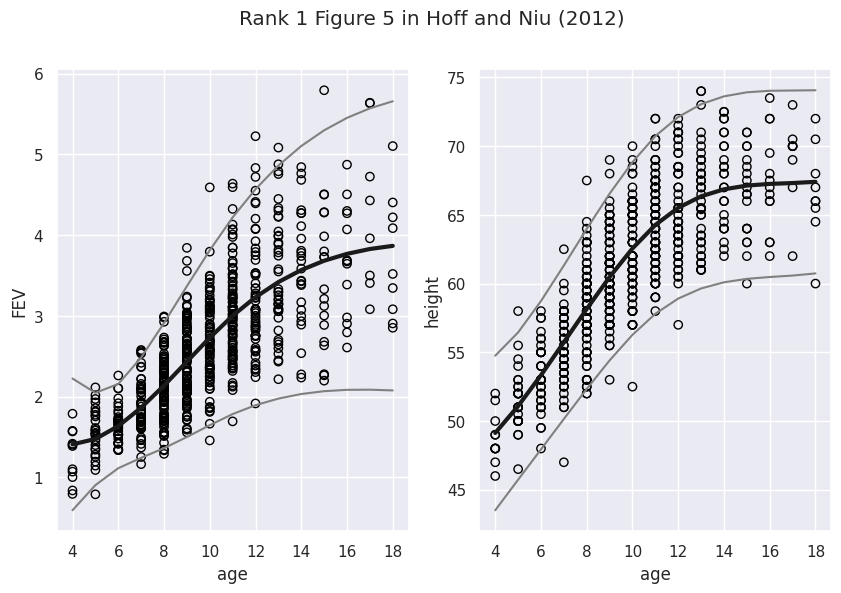

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.suptitle('Rank 1 Figure 5 in Hoff and Niu (2012)')
axs[0].scatter(peter_hoff_data['age'], peter_hoff_data['fev'], facecolor='none', edgecolor='black')
axs[0].plot(np.linspace(4, 18, 15), mean_fev, linewidth=3, c='k')
axs[0].plot(np.linspace(4, 18, 15), mean_fev + 2 * np.sqrt(cov_3d[0, 0, :]), c='grey')
axs[0].plot(np.linspace(4, 18, 15), mean_fev - 2 * np.sqrt(cov_3d[0, 0, :]), c='grey')
axs[0].set_xlabel('age')
axs[0].set_ylabel('FEV')
axs[0].set_xticks([4, 6, 8, 10, 12, 14, 16, 18])
axs[0].set_yticks([1, 2, 3, 4, 5, 6])
axs[1].scatter(peter_hoff_data['age'], peter_hoff_data['height'], facecolor='none', edgecolor='black')
axs[1].plot(np.linspace(4, 18, 15), mean_height, linewidth=3, c='k')
axs[1].plot(np.linspace(4, 18, 15), mean_height + 2 * np.sqrt(cov_3d[1, 1, :]), c='grey')
axs[1].plot(np.linspace(4, 18, 15), mean_height - 2 * np.sqrt(cov_3d[1, 1, :]), c='grey')
axs[1].set_xlabel('age')
axs[1].set_ylabel('height')
axs[1].set_xticks([4, 6, 8, 10, 12, 14, 16, 18])
axs[1].set_yticks([45, 50, 55, 60, 65, 70, 75])
plt.show()

## Plot Correlation

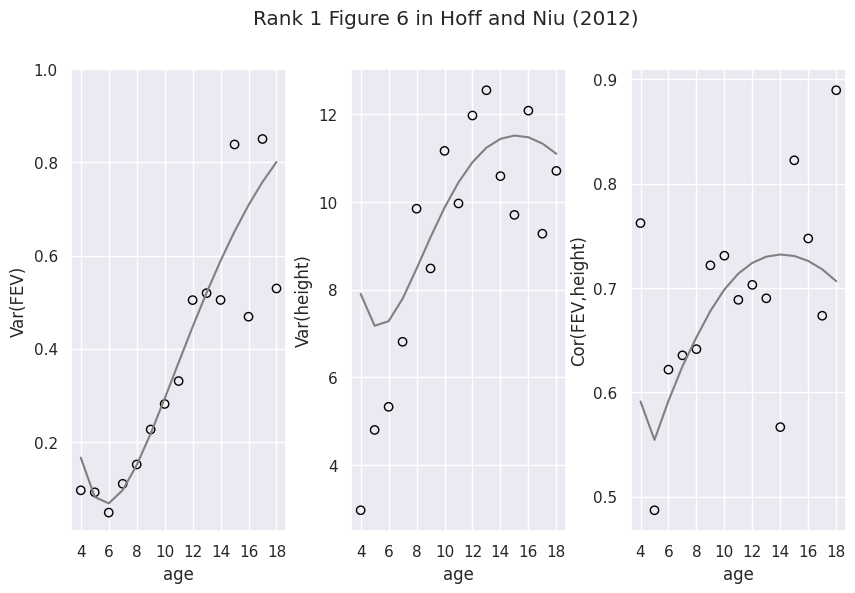

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
fig.suptitle('Rank 1 Figure 6 in Hoff and Niu (2012)')
axs[0].plot(np.linspace(4, 18, 15), cov_3d[0, 0, :], c='grey')
fev_var = np.zeros_like(np.linspace(4, 18, 15))
for i, age in enumerate(range(4, 19)):
    fev_var[i] = np.var(np.asarray(peter_hoff_data['fev'])[np.asarray(peter_hoff_data['age']) == age])
axs[0].scatter(np.linspace(4, 18, 15), fev_var, facecolor='none', edgecolor='black')
axs[0].set_xlabel('age')
axs[0].set_ylabel('Var(FEV)')
axs[0].set_xticks([4, 6, 8, 10, 12, 14, 16, 18])
axs[0].set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
axs[1].plot(np.linspace(4, 18, 15), cov_3d[1, 1, :], c='grey')
height_var = np.zeros_like(np.linspace(4, 18, 15))
for i, age in enumerate(range(4, 19)):
    height_var[i] = np.var(np.asarray(peter_hoff_data['height'])[np.asarray(peter_hoff_data['age']) == age])
axs[1].scatter(np.linspace(4, 18, 15), height_var, facecolor='none', edgecolor='black')
axs[1].set_xlabel('age')
axs[1].set_ylabel('Var(height)')
axs[1].set_xticks([4, 6, 8, 10, 12, 14, 16, 18])
axs[1].set_yticks([4, 6, 8, 10, 12])
axs[2].plot(np.linspace(4, 18, 15), cov_3d[0, 1, :] / (np.sqrt(cov_3d[0, 0, :]) * np.sqrt(cov_3d[1, 1, :])), c='grey')
fev_height_cov = np.zeros_like(np.linspace(4, 18, 15))
for i, age in enumerate(range(4, 19)):
    fev_height_cov[i] = np.corrcoef(np.asarray(peter_hoff_data['fev'])[np.asarray(peter_hoff_data['age']) == age],
                                    np.asarray(peter_hoff_data['height'])[
                                        np.asarray(peter_hoff_data['age']) == age])[0, 1]
axs[2].scatter(np.linspace(4, 18, 15), fev_height_cov, facecolor='none', edgecolor='black')
axs[2].set_xlabel('age')
axs[2].set_ylabel('Cor(FEV,height)')
axs[2].set_xticks([4, 6, 8, 10, 12, 14, 16, 18])
axs[2].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
plt.show()